# Enhancing Optimization Algorithms

# Momentum-Accelerated Gradient Descent

## Momentum-Accelerated Gradient Descent

A fundamental issue with the direction of the negative gradient: depending on the function being minimized, it can oscillate rapidly, leading to zig-zagging gradient descent steps that slow down minimization.

- A popular enhancement address this zig-zagging issue of the standard gradient descent step is **<font color='red'>momentum acceleration</font>**.

- The core idea comes from a tool for *smoothing time series data* known as the **<font color='red'>exponential average</font>**.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
import numpy as np
from autograd import grad as compute_grad   
import math
import time


class exponential_visualizer:
    '''
    animators for time series
    '''

    #### animate exponential average ####
    def animate_exponential_ave(self,x,y,savepath,**kwargs):
        # produce figure
        fig = plt.figure(figsize = (9,4))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1,7,1]) 
        ax = plt.subplot(gs[0]); ax.axis('off')
        ax1 = plt.subplot(gs[1]); 
        ax2 = plt.subplot(gs[2]); ax2.axis('off')
        artist = fig
        
        # view limits
        xmin = -3
        xmax = len(x) + 3
        ymin = np.min(x)
        ymax = np.max(x) 
        ygap = (ymax - ymin)*0.15
        ymin -= ygap
        ymax += ygap
            
        # start animation
        num_frames = len(y) 
        print ('starting animation rendering...')
        def animate(k):
            # clear panels
            ax1.cla()
            
            # print rendering update
            if np.mod(k+1,25) == 0:
                print ('rendering animation frame ' + str(k+1) + ' of ' + str(num_frames))
            if k == num_frames - 1:
                print ('animation rendering complete!')
                time.sleep(1.5)
                clear_output()
                
            # plot x
            ax1.plot(np.arange(1,x.size + 1),x,alpha = 1,color = 'k',linewidth = 2,zorder = 2);

            # plot exponential average - initial conditions
            if k == 1:
                ax1.plot(np.arange(1,2), y[:1], alpha = 0.75, c = 'darkorange',linewidth = 4,zorder = 3);
                
            # plot moving average - everything after and including initial conditions
            if k > 1:
                # plot 
                ax1.plot(np.arange(1,k+1),y[:k],alpha = 0.7,color = 'darkorange',linewidth = 4,zorder = 3);
                
            # label axes
            ax1.set_xlim([xmin,xmax])
            ax1.set_ylim([ymin,ymax])
            return artist,

        anim = animation.FuncAnimation(fig, animate ,frames=num_frames, interval=num_frames, blit=True)
        
        # produce animation and save
        fps = 50
        if 'fps' in kwargs:
            fps = kwargs['fps']
        anim.save(savepath, fps=fps, extra_args=['-vcodec', 'libx264'])
        clear_output()



class static_visualizer:
    '''
    Illustrate a run of your preferred optimization algorithm on a one or two-input function.  Run
    the algorithm first, and input the resulting weight history into this wrapper.
    ''' 

    ##### draw picture of function and run for two-input function ####       
    def two_input_contour_vert_plots(self,gs,histories,**kwargs):
        ##### construct figure with panels #####
        # construct figure
        fig = plt.figure(figsize = (10,7))

        # create figure with single plot for contour
        num_plots = len(histories)
        axs = gridspec.GridSpec(num_plots,1) 
        
        # remove whitespace from figure
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # remove whitespace
        fig.subplots_adjust(wspace=0.01,hspace=0.01)
        
        # define edgecolors 
        edgecolors = ['k','k','k','k','k']
        
        # loop over histories and plot
        for j in range(num_plots):
            # get next weight history
            w_hist = histories[j]
            g = gs[j]
            
            # create subplot
            ax = plt.subplot(axs[j],aspect='equal'); 

            ### make contour right plot - as well as horizontal and vertical axes ###
            self.contour_plot_setup(g,ax,**kwargs)           # draw contour plot
            self.edgecolor = edgecolors[j]
            self.draw_weight_path(ax,w_hist,**kwargs)        # draw path on contour plot

        # plot
        plt.show()
        
        
    ########################################################################################
    #### utility functions - for setting up / making contour plots, 3d surface plots, etc., ####
    # show contour plot of input function
    def contour_plot_setup(self,g,ax,**kwargs):
        xmin = -3.1
        xmax = 3.1
        ymin = -3.1
        ymax = 3.1
        if 'xmin' in kwargs:            
            xmin = kwargs['xmin']
        if 'xmax' in kwargs:
            xmax = kwargs['xmax']
        if 'ymin' in kwargs:            
            ymin = kwargs['ymin']
        if 'ymax' in kwargs:
            ymax = kwargs['ymax']      
        num_contours = 20
        if 'num_contours' in kwargs:
            num_contours = kwargs['num_contours']   
            
        # choose viewing range using weight history?
        if 'view_by_weights' in kwargs:
            view_by_weights = True
            weight_history = kwargs['weight_history']
            if view_by_weights == True:
                xmin = min([v[0] for v in weight_history])[0]
                xmax = max([v[0] for v in weight_history])[0]
                xgap = (xmax - xmin)*0.25
                xmin -= xgap
                xmax += xgap

                ymin = min([v[1] for v in weight_history])[0]
                ymax = max([v[1] for v in weight_history])[0]
                ygap = (ymax - ymin)*0.25
                ymin -= ygap
                ymax += ygap
 
        ### plot function as contours ###
        self.draw_contour_plot(g,ax,num_contours,xmin,xmax,ymin,ymax)
        
        ### cleanup panel ###
        ax.set_xlabel('$w_0$',fontsize = 14)
        ax.set_ylabel('$w_1$',fontsize = 14,labelpad = 15,rotation = 0)
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        # ax.set_xticks(np.arange(round(xmin),round(xmax)+1))
        # ax.set_yticks(np.arange(round(ymin),round(ymax)+1))
        
        # set viewing limits
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)

    ### function for creating contour plot
    def draw_contour_plot(self,g,ax,num_contours,xmin,xmax,ymin,ymax):
        #### define input space for function and evaluate ####
        w1 = np.linspace(xmin,xmax,400)
        w2 = np.linspace(ymin,ymax,400)
        w1_vals, w2_vals = np.meshgrid(w1,w2)
        w1_vals.shape = (len(w1)**2,1)
        w2_vals.shape = (len(w2)**2,1)
        h = np.concatenate((w1_vals,w2_vals),axis=1)
        func_vals = np.asarray([ g(np.reshape(s,(2,1))) for s in h])

        w1_vals.shape = (len(w1),len(w1))
        w2_vals.shape = (len(w2),len(w2))
        func_vals.shape = (len(w1),len(w2)) 
        
        ### make contour right plot - as well as horizontal and vertical axes ###
        # set level ridges
        levelmin = min(func_vals.flatten())
        levelmax = max(func_vals.flatten())
        cutoff = 1
        cutoff = (levelmax - levelmin)*cutoff
        numper = 4
        levels1 = np.linspace(cutoff,levelmax,numper)
        num_contours -= numper

        # produce generic contours
        levels2 = np.linspace(levelmin,cutoff,min(num_contours,numper))
        levels = np.unique(np.append(levels1,levels2))
        num_contours -= numper
        while num_contours > 0:
            cutoff = levels[1]
            levels2 = np.linspace(levelmin,cutoff,min(num_contours,numper))
            levels = np.unique(np.append(levels2,levels))
            num_contours -= numper
   
        # plot the contours
        ax.contour(w1_vals, w2_vals, func_vals,levels = levels[1:],colors = 'k')
        ax.contourf(w1_vals, w2_vals, func_vals,levels = levels,cmap = 'Blues')

        ###### clean up plot ######
        ax.set_xlabel('$w_0$',fontsize = 12)
        ax.set_ylabel('$w_1$',fontsize = 12,rotation = 0)
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        
        
    ### makes color spectrum for plotted run points - from green (start) to red (stop)
    def make_colorspec(self,w_hist):
        # make color range for path
        s = np.linspace(0,1,len(w_hist[:round(len(w_hist)/2)]))
        s.shape = (len(s),1)
        t = np.ones(len(w_hist[round(len(w_hist)/2):]))
        t.shape = (len(t),1)
        s = np.vstack((s,t))
        colorspec = []
        colorspec = np.concatenate((s,np.flipud(s)),1)
        colorspec = np.concatenate((colorspec,np.zeros((len(s),1))),1)
        return colorspec


    ### function for drawing weight history path
    def draw_grads(self,ax,directions,**kwargs):
        # make colors for plot
        colorspec = self.make_colorspec(directions)

        arrows = True
        if 'arrows' in kwargs:
            arrows = kwargs['arrows']
            
        # plot axes
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        
        ### plot function decrease plot in right panel
        for j in range(len(directions)):  
            # get current direction
            direction = directions[j]
            
            # draw arrows connecting pairwise points
            head_length = 0.1
            head_width = 0.1
            ax.arrow(0,0,direction[0],direction[1], head_width=head_width, head_length=head_length, fc='k', ec='k',linewidth=1,zorder = 2,length_includes_head=True)
            ax.arrow(0,0,direction[0],direction[1], head_width=0.1, head_length=head_length, fc=colorspec[j], ec=colorspec[j],linewidth=0.25,zorder = 2,length_includes_head=True)

    ### function for drawing weight history path
    def draw_grads_v2(self,ax,directions,**kwargs):
        arrows = True
        if 'arrows' in kwargs:
            arrows = kwargs['arrows']
            
        # plot axes
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        
        ### plot function decrease plot in right panel
        head_length = 0.1
        head_width = 0.1
        alpha = 0.1
        for j in range(len(directions)-1):  
            # get current direction
            direction = directions[j]
            
            # draw arrows connecting pairwise points
            ax.arrow(0,0,direction[0],direction[1], head_width=head_width, head_length=head_length, fc='k', ec='k',linewidth=3.5,zorder = 2,length_includes_head=True,alpha = alpha)
            ax.arrow(0,0,direction[0],direction[1], head_width=0.1, head_length=head_length, fc=self.colorspec[j], ec=self.colorspec[j],linewidth=3,zorder = 2,length_includes_head=True,alpha = alpha)
            
        # plot most recent direction
        direction = directions[-1]
        num_dirs = len(directions)
  
        # draw arrows connecting pairwise points
        ax.arrow(0,0,direction[0],direction[1], head_width=head_width, head_length=head_length, fc='k', ec='k',linewidth=4,zorder = 2,length_includes_head=True)
        ax.arrow(0,0,direction[0],direction[1], head_width=0.1, head_length=head_length, fc=self.colorspec[num_dirs], ec=self.colorspec[num_dirs],linewidth=3,zorder = 2,length_includes_head=True)            
            
    ### function for drawing weight history path
    def draw_weight_path(self,ax,w_hist,**kwargs):
        # make colors for plot
        colorspec = self.make_colorspec(w_hist)
        
        arrows = True
        if 'arrows' in kwargs:
            arrows = kwargs['arrows']

        ### plot function decrease plot in right panel
        for j in range(len(w_hist)):  
            w_val = w_hist[j]

            # plot each weight set as a point
            ax.scatter(w_val[0],w_val[1],s = 80,color = colorspec[j],edgecolor = self.edgecolor,linewidth = 2*math.sqrt((1/(float(j) + 1))),zorder = 3)

            # plot connector between points for visualization purposes
            if j > 0:
                pt1 = w_hist[j-1]
                pt2 = w_hist[j]
                
                # produce scalar for arrow head length
                pt_length = np.linalg.norm(pt1 - pt2)
                head_length = 0.1
                alpha = (head_length - 0.35)/pt_length + 1
                
                # if points are different draw error
                if np.linalg.norm(pt1 - pt2) > head_length and arrows == True:
                    if np.ndim(pt1) > 1:
                        pt1 = pt1.flatten()
                        pt2 = pt2.flatten()
                        
                        
                    # draw color connectors for visualization
                    w_old = pt1
                    w_new = pt2
                    ax.plot([w_old[0],w_new[0]],[w_old[1],w_new[1]],color = colorspec[j],linewidth = 2,alpha = 1,zorder = 2)      # plot approx
                    ax.plot([w_old[0],w_new[0]],[w_old[1],w_new[1]],color = 'k',linewidth = 3,alpha = 1,zorder = 1)      # plot approx
                
                
                    # draw arrows connecting pairwise points
                    #ax.arrow(pt1[0],pt1[1],(pt2[0] - pt1[0])*alpha,(pt2[1] - pt1[1])*alpha, head_width=0.1, head_length=head_length, fc='k', ec='k',linewidth=4,zorder = 2,length_includes_head=True)
                    #ax.arrow(pt1[0],pt1[1],(pt2[0] - pt1[0])*alpha,(pt2[1] - pt1[1])*alpha, head_width=0.1, head_length=head_length, fc='w', ec='w',linewidth=0.25,zorder = 2,length_includes_head=True)
        
    ### draw surface plot
    def draw_surface(self,g,ax,**kwargs):
        xmin = -3.1
        xmax = 3.1
        ymin = -3.1
        ymax = 3.1
        if 'xmin' in kwargs:            
            xmin = kwargs['xmin']
        if 'xmax' in kwargs:
            xmax = kwargs['xmax']
        if 'ymin' in kwargs:            
            ymin = kwargs['ymin']
        if 'ymax' in kwargs:
            ymax = kwargs['ymax']   
            
        #### define input space for function and evaluate ####
        w1 = np.linspace(xmin,xmax,200)
        w2 = np.linspace(ymin,ymax,200)
        w1_vals, w2_vals = np.meshgrid(w1,w2)
        w1_vals.shape = (len(w1)**2,1)
        w2_vals.shape = (len(w2)**2,1)
        h = np.concatenate((w1_vals,w2_vals),axis=1)
        func_vals = np.asarray([g(np.reshape(s,(2,1))) for s in h])

        ### plot function as surface ### 
        w1_vals.shape = (len(w1),len(w2))
        w2_vals.shape = (len(w1),len(w2))
        func_vals.shape = (len(w1),len(w2))
        ax.plot_surface(w1_vals, w2_vals, func_vals, alpha = 0.1,color = 'w',rstride=25, cstride=25,linewidth=1,edgecolor = 'k',zorder = 2)

        # plot z=0 plane 
        ax.plot_surface(w1_vals, w2_vals, func_vals*0, alpha = 0.1,color = 'w',zorder = 1,rstride=25, cstride=25,linewidth=0.3,edgecolor = 'k') 
                
        # clean up axis
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.xaxis.pane.set_edgecolor('white')
        ax.yaxis.pane.set_edgecolor('white')
        ax.zaxis.pane.set_edgecolor('white')

        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        
        ax.set_xlabel('$w_0$',fontsize = 14)
        ax.set_ylabel('$w_1$',fontsize = 14,rotation = 0)
        ax.set_title('$g(w_0,w_1)$',fontsize = 14)
        

    ### plot points and connectors in input space in 3d plot        
    def show_inputspace_path(self,w_hist,ax):
        # make colors for plot
        colorspec = self.make_colorspec(w_hist)
        
        for k in range(len(w_hist)):
            pt1 = w_hist[k]
            ax.scatter(pt1[0],pt1[1],0,s = 60,color = colorspec[k],edgecolor = 'k',linewidth = 0.5*math.sqrt((1/(float(k) + 1))),zorder = 3)
            if k < len(w_hist)-1:
                pt2 = w_hist[k+1]
                if np.linalg.norm(pt1 - pt2) > 10**(-3):
                    # draw arrow in left plot
                    a = Arrow3D([pt1[0],pt2[0]], [pt1[1],pt2[1]], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="k")
                    ax.add_artist(a)
        
#### custom 3d arrow and annotator functions ###    
# nice arrow maker from https://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")


In [4]:
# data paths
data_path_1 = './ford_data.csv'

# video paths
video_path_1 = './video_1.mp4'
video_path_2 = './video_2.mp4'

demo_1 = exponential_visualizer()
demo_2 = exponential_visualizer()

## The exponential average

- A general time series data consists of a sequence of $K$ ordered points $w^1,\,w^2,\,...,w^K$. 

- For example, a history of the price of a stock over $K=528$ periods of time.

In [5]:
# load in data
data = pd.read_csv(data_path_1)
x = np.array(data['Close'])    # date: 1980 to 2017

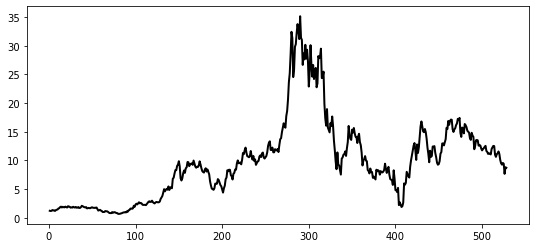

In [6]:
fig = plt.figure(figsize = (9,4))
plt.plot(np.arange(1,x.size + 1),x,alpha = 1,color = 'k',linewidth = 2,zorder = 2);

- Or, we run a local optimization method with steps $\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha \mathbf{d}^{k-1}$ which produces the time series sequence of ordered points $\mathbf{w}^{1},\,\mathbf{w}^{2},\,...,\mathbf{w}^{K}$ that are multi-dimensional.

- The raw values of a time series often zig-zag up and down, it is common to **<font color='red'>smooth</font>** them for better visualization or prior to further analysis.

- First, we consider how to compute a **cumulative average** of $K$ input points $w^1,\,w^2,\,...,w^K$, that is the average of the first two points, the average of the first three points, and so forth.

\begin{array}
\
\text{average of the first $1$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^1 = w^1 \\
\text{average of the first $2$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^2 = \frac{w^1 + w^2}{2} \\
\text{average of the first $3$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^3 = \frac{w^1 + w^2 + w^3}{3} \\
\text{average of the first $4$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^4 = \frac{w^1 + w^2 + w^3 + w^4}{4} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{average of the first $k$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^{k} = \frac{w^1 + w^2 + w^3 + w^4 + \cdots  + w^k}{k} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\end{array}

- At each step here the average computation $h^k$ *summarizes* the input points $w^1$ through $w^k$ via a simple summary statistic: their <font color='red'>sample mean</font>.  
- We *need every raw point $w^1$ through $w^k$* in order to compute the running average $h^k$.

- We can write the cumulative average by expressing $h^k$ for $k>1$ in a <font color='red'>recursive manner</font> involving only its prceding cumulative average $h^{k-1}$ and the current time series value $w^k$ as:
    
\begin{equation*}
h^{k} = \frac{k-1}{k}h^{k-1} + \frac{1}{k}w^k.
\end{equation*}

- This is more efficient because we only need to store two values.

- In the above running average formula, the two coefficients of the update always sum to 1, i.e., $\frac{k-1}{k} + \frac{1}{k} = 1$ for all $k$. As $k$ grows larger, the coefficient on $h^{k-1}$ gets closer to 1, while the one one $w^k$ gets closer to 0.

- To create the **<font color='red'>exponential average</font>**, we freeze these coefficients: i.e., the coefficient on $h^{k-1}$ is set to a constant $\beta\in[0,1]$, and the coefficient on $w^k$ is set to $1-\beta$.

\begin{equation*}
h^{k} = \beta \, h^{k-1} +  \left(1 - \beta\right)w^k.
\end{equation*}

- $\beta$ controls a **<font color='blue'>tradeoff</font>**: the smaller $\beta$ the more our exponential average approximates the raw (zig-zagging) time series itself, while the larger $\beta$ the more each subsequent average looks like its predecessor.

- By using the exponential averaging formula and substituting in the value of each preceeding value $h^{k-1}$, all the way back to $h^1$, we can 'roll back' the exponential average at each step so that $h^k$ is expressed entirely in terms of the input values $w^1$ through $w^k$ preceeding it.

\begin{equation*}
h^{k} = \beta \, h^{k-1} +  \left(1 - \beta\right)w^k.
\end{equation*}

substituting in the same formula for $h^{k-1} = \beta \, h^{k-2} +  \left(1 - \beta\right)w^{k-1}$ into the right hand side above for $h^k$, we have:

\begin{align*}
h^k &= \beta \, h^{k-1} +  \left(1 - \beta\right)w^k \\
&= \beta\left(\beta\, h^{k-2} + \left(1 - \beta\right)w^{k-1}\right) + \left(1 - \beta\right) w^k\\
&= \left(\beta\right)^2 \, h^{k-2} + \beta  \left(1 - \beta\right)w^{k-1} + \left(1 - \beta\right) w^k\\
&= \ldots\\
&= \left(\beta\right)^{\,k} \, w^1 + \left(\beta\right)^{\,k-1}\,\left(1 - \beta\right) w^{2} + \left(\beta\right)^{\,k-2}\left(1 - \beta\right)w^3 + \cdots  + \beta\,\left(1 - \beta\right)w^{k-1}  + \left(1 - \beta\right)w^k 
\end{align*}

- Similarly, the exponential average of a time series of general $N$ dimensional points  $\mathbf{w}^1,\,\mathbf{w}^2,\,...,\mathbf{w}^K$ can be computed by initializing $\mathbf{h}^1 = \mathbf{w}^1$ and then for $k > 1$ building $\mathbf{h}^k$ as 

\begin{equation*}
\mathbf{h}^{k} = \beta \, \mathbf{h}^{k-1} +  \left(1 - \beta\right)\mathbf{w}^k.
\end{equation*}

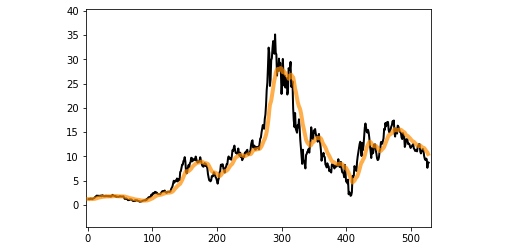

In [7]:
def exponential_average(x,alpha):
    h = [x[0]]
    for p in range(len(x) - 1):
        # get next element of input series
        x_p = x[p]        
        # make next hidden state
        h_p = alpha*h[-1] + (1 - alpha)*x_p
        h.append(h_p)
    return np.array(h)
# produce moving average time series
alpha = 0.9
h = exponential_average(x,alpha)
demo_1.animate_exponential_ave(x,h,savepath=video_path_1)

In [8]:
show_video(video_path_1, width=800)

We zoom-in for the first 100 points.

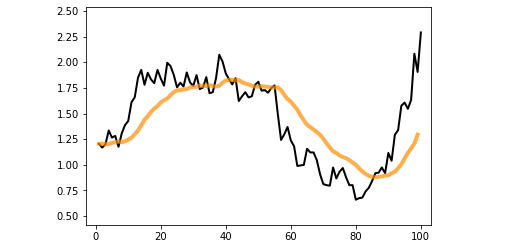

In [9]:
demo_2.animate_exponential_ave(x[:100],h[:100],savepath=video_path_2)

In [10]:
show_video(video_path_2, width=800)

## Ameliorating the zig-zag behavior of gradient descent

In [11]:
# import autograd-wrapped numpy
import autograd.numpy as np
from autograd import value_and_grad 

In [12]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def momentum(g,alpha_choice,beta,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    cost_eval,grad_eval = gradient(w)
    
    # initialization for momentum direction
    h = np.zeros((w.shape))
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)
        
        #### momentum step - update exponential average of gradient directions to ameliorate zig-zagging ###
        h = beta*h - (1 - beta)*grad_eval

        # take gradient descent step
        w = w + alpha*h
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

In [13]:
static_plotter = static_visualizer()

The gradient descent update rule

\begin{equation*}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation*}

suffers from zig-zagging behavior that slows progress of minimization.

- Both our sequence of gradient descent steps *and* the negative gradient directions themselves are both *time series*.

- If we take $K$ steps of gradient descent using the form above we do create an time series of ordered *gradient descent steps* $\mathbf{w}^1,\,\mathbf{w}^{2},\,...,\mathbf{w}^{K}$ and descent directinos $-\nabla g\left(\mathbf{w}^{0}\right),\,-\nabla g\left(\mathbf{w}^{1}\right),...,-\nabla g\left(\mathbf{w}^{K-1}\right)$.

- To ameliorate some of the zig-zagging behavior of our gradient descent steps  $\mathbf{w}^1,\,\mathbf{w}^{1},\,...,\mathbf{w}^{K}$ we could compute their *<font color='red'>exponential average</font>*.

- However we do not want to smooth the gradient descent steps *after* they have been created - the 'damage is already done' in the sense that the zig-zagging has already slowed the progress of a gradient descent run.

- Instead what we want is to smooth the steps *<font color='blue'>as they are created</font>*, so that our algorithm makes more progress in minimization.

- The root cause of zig-zagging gradient descent steps zig-zag is the oscillating nature of the (negative) gradient directions themselves.

- If the descent directions $-\nabla g\left(\mathbf{w}^{0}\right),\,-\nabla g\left(\mathbf{w}^{1}\right),...,-\nabla g\left(\mathbf{w}^{K-1}\right)$ zig-zag, so to will the gradient descent steps.

- Using the exponential average, we will to create our smoothed descent directions as they are created.

- We initialize $\mathbf{d}^0 = -\nabla g\left(\mathbf{w}^0\right)$ and then for $k -1 > 0$ the $\left(k-1\right)^{th}$ exponentially averaged descent direction $\mathbf{d}^{k-1}$ takes the form:

\begin{equation*}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2} +  \left(1 - \beta\right)\left(-\nabla g\left(\mathbf{w}^{k-1}\right)\right)
\end{equation*}

- The update in our gradient descent now becomes:
\begin{equation*}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2}  + \left(1 - \beta\right)\left(-\nabla g\left(\mathbf{w}^{k-1}\right)\right) \\
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \, \mathbf{d}^{k-1}. \,\,\,\,\,\,\,\,\,\,\,\,\,     \,\,\,\,\,\,\,\,\,\,\,\,\,      \,\,\,
\end{equation*}

- This adjustment to gradient descent is often called **<font color='red'>momentum accelerated gradient descent</font>**. The term ''momentum'' refers to the exponentially averaged descent direction $\mathbf{d}^{k-1}$.

\begin{equation*}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2} +  \left(1 - \beta\right)\left(-\nabla g\left(\mathbf{w}^{k-1}\right)\right)
\end{equation*}

The choice of $\beta \in \left[0,1\right]$ provides a trade-off:
- The smaller $\beta$ is chosen the *more* the exponential average resembles the actual sequence of negative descent directions since *more* of each negative gradient direction is used in the update.
- The larger $\beta$ is chosen the *less* these exponentially averaged descent steps resemble the negative gradient directions, since each update will use *less* of each subsequent negative gradient direction.
- Often in practice larger values of $\beta$ are used, in the range $\left[0.7,1\right]$.

- In practice this step is also written slightly differently: instead of averaging the *negative* gradient directions, the gradient itself is exponentially averaged, and then the *step* is taken in their *negative* direction.

- This means that we initialize our exponential average at the first *negative* descent direction $\mathbf{d}^0 = -\nabla g\left(\mathbf{w}^0\right)$ and for $k-1 > 0$ the general descent direction and corresponding step is computed as

\begin{equation*}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2} +  \left(1 - \beta\right)\nabla g\left(\mathbf{w}^{k-1}\right) \\
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \, \mathbf{d}^{k-1}. \,\,\,\,\,\,\,\,\,\,\,\,\,     \,\,\,\,\,\,\,\,\,\,\,\,\,      \,\,\,
\end{equation*}

### Example: Accelerating gradient descent on a simple quadratic

Using a quadratic function of the form

\begin{equation*}
g(\mathbf{w}) = a + \mathbf{b}^T\mathbf{w} + \mathbf{w}^T\mathbf{C}\mathbf{w}.
\end{equation*}

where $a=0, \, \mathbf{b}=\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \, \mathbf{C} = \begin{bmatrix} 0.5 & 0 \\ 0 & 9.75\end{bmatrix}$.

- We run $25$ gradient descent steps, and also compare two run of *momentum accelerated graient descent* with two choices for $\beta \in \{0.2, 0.7\}$. 
- All three runs are initialized at the same point $\mathbf{w}^0 = \begin{bmatrix} 10 \\ 1 \end{bmatrix}$ and use the same learning rate $\alpha = 10^{-1}$.  

In [14]:
# define constants for a N=2 input quadratic
a1 = 0
b1 = 0*np.ones((2,1))
C1 = np.array([[0.5,0],[0,9.75]])

# a quadratic function defined using the constants above
g = lambda w: (a1 + np.dot(b1.T,w) + np.dot(np.dot(w.T,C1),w))[0]

w = np.array([10.0,1.0]); max_its = 25; alpha_choice = 10**(-1);
beta = 0
weight_history_1,cost_history_1 = momentum(g,alpha_choice,beta,max_its,w)

beta = 0.1;
weight_history_2,cost_history_2 = momentum(g,alpha_choice,beta,max_its,w)

beta = 0.7
weight_history_3,cost_history_3 = momentum(g,alpha_choice,beta,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
histories = [weight_history_1,weight_history_2,weight_history_3]
gs = [g,g,g]

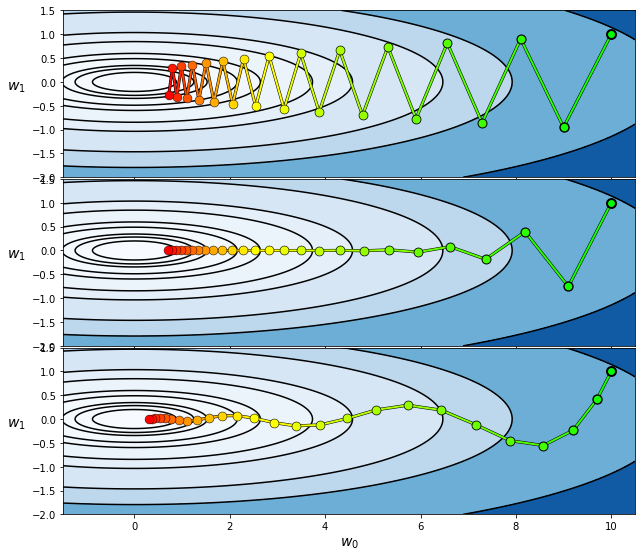

In [15]:
static_plotter.two_input_contour_vert_plots(gs,histories,num_contours = 25,xmin = -1.5,xmax = 10.5,ymin = -2.0,ymax = 1.5)

# Normalized Gradient Descent

In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import clear_output
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform

from autograd import grad as compute_grad   
import autograd.numpy as np
import math
import time


class static_visualizer:
    '''
    Illustrate a run of your preferred optimization algorithm on a one or two-input function.  Run
    the algorithm first, and input the resulting weight history into this wrapper.
    ''' 

    ##### draw picture of function and run for single-input function ####       
    def single_input_plot(self,g,weight_histories,cost_histories,**kwargs):        
        # adjust viewing range
        wmin = -3.1
        wmax = 3.1
        if 'wmin' in kwargs:            
            wmin = kwargs['wmin']
        if 'wmax' in kwargs:
            wmax = kwargs['wmax']
            
        onerun_perplot = False
        if 'onerun_perplot' in kwargs:
            onerun_perplot = kwargs['onerun_perplot']
            
        ### initialize figure
        fig = plt.figure(figsize = (9,4))
        artist = fig
        
        # remove whitespace from figure
        #fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # remove whitespace
        #fig.subplots_adjust(wspace=0.01,hspace=0.01)

        # create subplot with 2 panels, plot input function in center plot
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
        ax1 = plt.subplot(gs[0]); 
        ax2 = plt.subplot(gs[1]); 

        ### plot function in both panels
        w_plot = np.linspace(wmin,wmax,500)
        g_plot = g(w_plot)
        gmin = np.min(g_plot)
        gmax = np.max(g_plot)
        g_range = gmax - gmin
        ggap = g_range*0.1
        gmin -= ggap
        gmax += ggap
        
        # plot function, axes lines
        ax1.plot(w_plot,g_plot,color = 'k',zorder = 2)                           # plot function
        ax1.axhline(y=0, color='k',zorder = 1,linewidth = 0.25)
        ax1.axvline(x=0, color='k',zorder = 1,linewidth = 0.25)
        ax1.set_xlabel(r'$w$',fontsize = 13)
        ax1.set_ylabel(r'$g(w)$',fontsize = 13,rotation = 0,labelpad = 25)            
        ax1.set_xlim(wmin,wmax)
        ax1.set_ylim(gmin,gmax)
        
        ax2.plot(w_plot,g_plot,color = 'k',zorder = 2)                           # plot function
        ax2.axhline(y=0, color='k',zorder = 1,linewidth = 0.25)
        ax2.axvline(x=0, color='k',zorder = 1,linewidth = 0.25)
        ax2.set_xlabel(r'$w$',fontsize = 13)
        ax2.set_ylabel(r'$g(w)$',fontsize = 13,rotation = 0,labelpad = 25)   
        ax2.set_xlim(wmin,wmax)
        ax2.set_ylim(gmin,gmax)        
       
        #### loop over histories and plot each
        for j in range(len(weight_histories)):
            w_hist = weight_histories[j]
            c_hist = cost_histories[j]
            
            # colors for points --> green as the algorithm begins, yellow as it converges, red at final point
            s = np.linspace(0,1,len(w_hist[:round(len(w_hist)/2)]))
            s.shape = (len(s),1)
            t = np.ones(len(w_hist[round(len(w_hist)/2):]))
            t.shape = (len(t),1)
            s = np.vstack((s,t))
            self.colorspec = []
            self.colorspec = np.concatenate((s,np.flipud(s)),1)
            self.colorspec = np.concatenate((self.colorspec,np.zeros((len(s),1))),1)
            
            ### plot all history points
            ax = ax2
            if onerun_perplot == True:
                if j == 0:
                    ax = ax1
                if j == 1:
                    ax = ax2
            for k in range(len(w_hist)):
                # pick out current weight and function value from history, then plot
                w_val = w_hist[k]
                g_val = c_hist[k]
                ax.scatter(w_val,g_val,s = 90,color = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4),zorder = 3,marker = 'X')            # evaluation on function
                ax.scatter(w_val,0,s = 90,facecolor = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4), zorder = 3)

    ##### draw picture of function and run for two-input function ####       
    def two_input_surface_contour_plot(self,g,w_hist,**kwargs):
        ### input arguments ###        
        num_contours = 10
        if 'num_contours' in kwargs:
            num_contours = kwargs['num_contours']
           
        view = [20,20]
        if 'view' in kwargs:
            view = kwargs['view']
            
        ##### construct figure with panels #####
        # construct figure
        fig = plt.figure(figsize = (11,5))
        self.edgecolor = 'k'

        # create subplot with 3 panels, plot input function in center plot
        # this seems to be the best option for whitespace management when using
        # both a surface and contour plot in the same figure
        gs = gridspec.GridSpec(1, 3, width_ratios=[1,5,10]) 
        ax1 = plt.subplot(gs[1],projection='3d'); 
        ax2 = plt.subplot(gs[2],aspect='equal'); 
        
        # remove whitespace from figure
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # remove whitespace
        fig.subplots_adjust(wspace=0.01,hspace=0.01)
        
        # plot 3d surface and path in left panel
        self.draw_surface(g,ax1,**kwargs)
        self.show_inputspace_path(w_hist,ax1)
        ax1.view_init(view[0],view[1])
        
        ### make contour right plot - as well as horizontal and vertical axes ###
        self.contour_plot_setup(g,ax2,**kwargs)  # draw contour plot
        self.draw_weight_path(ax2,w_hist)              # draw path on contour plot

        # plot
        plt.show()
 


        
    ########################################################################################
    #### utility functions - for setting up / making contour plots, 3d surface plots, etc., ####
    # show contour plot of input function
    def contour_plot_setup(self,g,ax,**kwargs):
        xmin = -3.1
        xmax = 3.1
        ymin = -3.1
        ymax = 3.1
        if 'xmin' in kwargs:            
            xmin = kwargs['xmin']
        if 'xmax' in kwargs:
            xmax = kwargs['xmax']
        if 'ymin' in kwargs:            
            ymin = kwargs['ymin']
        if 'ymax' in kwargs:
            ymax = kwargs['ymax']      
        num_contours = 20
        if 'num_contours' in kwargs:
            num_contours = kwargs['num_contours']   
            
        # choose viewing range using weight history?
        if 'view_by_weights' in kwargs:
            view_by_weights = True
            weight_history = kwargs['weight_history']
            if view_by_weights == True:
                xmin = min([v[0] for v in weight_history])[0]
                xmax = max([v[0] for v in weight_history])[0]
                xgap = (xmax - xmin)*0.25
                xmin -= xgap
                xmax += xgap

                ymin = min([v[1] for v in weight_history])[0]
                ymax = max([v[1] for v in weight_history])[0]
                ygap = (ymax - ymin)*0.25
                ymin -= ygap
                ymax += ygap
 
        ### plot function as contours ###
        self.draw_contour_plot(g,ax,num_contours,xmin,xmax,ymin,ymax)
        
        ### cleanup panel ###
        ax.set_xlabel('$w_0$',fontsize = 14)
        ax.set_ylabel('$w_1$',fontsize = 14,labelpad = 15,rotation = 0)
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        # ax.set_xticks(np.arange(round(xmin),round(xmax)+1))
        # ax.set_yticks(np.arange(round(ymin),round(ymax)+1))
        
        # set viewing limits
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)

    ### function for creating contour plot
    def draw_contour_plot(self,g,ax,num_contours,xmin,xmax,ymin,ymax):
        #### define input space for function and evaluate ####
        w1 = np.linspace(xmin,xmax,400)
        w2 = np.linspace(ymin,ymax,400)
        w1_vals, w2_vals = np.meshgrid(w1,w2)
        w1_vals.shape = (len(w1)**2,1)
        w2_vals.shape = (len(w2)**2,1)
        h = np.concatenate((w1_vals,w2_vals),axis=1)
        func_vals = np.asarray([ g(np.reshape(s,(2,1))) for s in h])

        w1_vals.shape = (len(w1),len(w1))
        w2_vals.shape = (len(w2),len(w2))
        func_vals.shape = (len(w1),len(w2)) 
        
        ### make contour right plot - as well as horizontal and vertical axes ###
        # set level ridges
        levelmin = min(func_vals.flatten())
        levelmax = max(func_vals.flatten())
        cutoff = 1
        cutoff = (levelmax - levelmin)*cutoff
        numper = 4
        levels1 = np.linspace(cutoff,levelmax,numper)
        num_contours -= numper

        # produce generic contours
        levels2 = np.linspace(levelmin,cutoff,min(num_contours,numper))
        levels = np.unique(np.append(levels1,levels2))
        num_contours -= numper
        while num_contours > 0:
            cutoff = levels[1]
            levels2 = np.linspace(levelmin,cutoff,min(num_contours,numper))
            levels = np.unique(np.append(levels2,levels))
            num_contours -= numper
   
        # plot the contours
        ax.contour(w1_vals, w2_vals, func_vals,levels = levels[1:],colors = 'k')
        ax.contourf(w1_vals, w2_vals, func_vals,levels = levels,cmap = 'Blues')

        ###### clean up plot ######
        ax.set_xlabel('$w_0$',fontsize = 12)
        ax.set_ylabel('$w_1$',fontsize = 12,rotation = 0)
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        
        
    ### makes color spectrum for plotted run points - from green (start) to red (stop)
    def make_colorspec(self,w_hist):
        # make color range for path
        s = np.linspace(0,1,len(w_hist[:round(len(w_hist)/2)]))
        s.shape = (len(s),1)
        t = np.ones(len(w_hist[round(len(w_hist)/2):]))
        t.shape = (len(t),1)
        s = np.vstack((s,t))
        colorspec = []
        colorspec = np.concatenate((s,np.flipud(s)),1)
        colorspec = np.concatenate((colorspec,np.zeros((len(s),1))),1)
        return colorspec


    ### function for drawing weight history path
    def draw_grads(self,ax,directions,**kwargs):
        # make colors for plot
        colorspec = self.make_colorspec(directions)

        arrows = True
        if 'arrows' in kwargs:
            arrows = kwargs['arrows']
            
        # plot axes
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        
        ### plot function decrease plot in right panel
        for j in range(len(directions)):  
            # get current direction
            direction = directions[j]
            
            # draw arrows connecting pairwise points
            head_length = 0.1
            head_width = 0.1
            ax.arrow(0,0,direction[0],direction[1], head_width=head_width, head_length=head_length, fc='k', ec='k',linewidth=1,zorder = 2,length_includes_head=True)
            ax.arrow(0,0,direction[0],direction[1], head_width=0.1, head_length=head_length, fc=colorspec[j], ec=colorspec[j],linewidth=0.25,zorder = 2,length_includes_head=True)

    ### function for drawing weight history path
    def draw_grads_v2(self,ax,directions,**kwargs):
        arrows = True
        if 'arrows' in kwargs:
            arrows = kwargs['arrows']
            
        # plot axes
        ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
        ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
        
        ### plot function decrease plot in right panel
        head_length = 0.1
        head_width = 0.1
        alpha = 0.1
        for j in range(len(directions)-1):  
            # get current direction
            direction = directions[j]
            
            # draw arrows connecting pairwise points
            ax.arrow(0,0,direction[0],direction[1], head_width=head_width, head_length=head_length, fc='k', ec='k',linewidth=3.5,zorder = 2,length_includes_head=True,alpha = alpha)
            ax.arrow(0,0,direction[0],direction[1], head_width=0.1, head_length=head_length, fc=self.colorspec[j], ec=self.colorspec[j],linewidth=3,zorder = 2,length_includes_head=True,alpha = alpha)
            
        # plot most recent direction
        direction = directions[-1]
        num_dirs = len(directions)
  
        # draw arrows connecting pairwise points
        ax.arrow(0,0,direction[0],direction[1], head_width=head_width, head_length=head_length, fc='k', ec='k',linewidth=4,zorder = 2,length_includes_head=True)
        ax.arrow(0,0,direction[0],direction[1], head_width=0.1, head_length=head_length, fc=self.colorspec[num_dirs], ec=self.colorspec[num_dirs],linewidth=3,zorder = 2,length_includes_head=True)            
            
    ### function for drawing weight history path
    def draw_weight_path(self,ax,w_hist,**kwargs):
        # make colors for plot
        colorspec = self.make_colorspec(w_hist)
        
        arrows = True
        if 'arrows' in kwargs:
            arrows = kwargs['arrows']

        ### plot function decrease plot in right panel
        for j in range(len(w_hist)):  
            w_val = w_hist[j]

            # plot each weight set as a point
            ax.scatter(w_val[0],w_val[1],s = 80,color = colorspec[j],edgecolor = self.edgecolor,linewidth = 2*math.sqrt((1/(float(j) + 1))),zorder = 3)

            # plot connector between points for visualization purposes
            if j > 0:
                pt1 = w_hist[j-1]
                pt2 = w_hist[j]
                
                # produce scalar for arrow head length
                pt_length = np.linalg.norm(pt1 - pt2)
                head_length = 0.1
                alpha = (head_length - 0.35)/pt_length + 1
                
                # if points are different draw error
                if np.linalg.norm(pt1 - pt2) > head_length and arrows == True:
                    if np.ndim(pt1) > 1:
                        pt1 = pt1.flatten()
                        pt2 = pt2.flatten()
                        
                        
                    # draw color connectors for visualization
                    w_old = pt1
                    w_new = pt2
                    ax.plot([w_old[0],w_new[0]],[w_old[1],w_new[1]],color = colorspec[j],linewidth = 2,alpha = 1,zorder = 2)      # plot approx
                    ax.plot([w_old[0],w_new[0]],[w_old[1],w_new[1]],color = 'k',linewidth = 3,alpha = 1,zorder = 1)      # plot approx
                
                
                    # draw arrows connecting pairwise points
                    #ax.arrow(pt1[0],pt1[1],(pt2[0] - pt1[0])*alpha,(pt2[1] - pt1[1])*alpha, head_width=0.1, head_length=head_length, fc='k', ec='k',linewidth=4,zorder = 2,length_includes_head=True)
                    #ax.arrow(pt1[0],pt1[1],(pt2[0] - pt1[0])*alpha,(pt2[1] - pt1[1])*alpha, head_width=0.1, head_length=head_length, fc='w', ec='w',linewidth=0.25,zorder = 2,length_includes_head=True)
        
    ### draw surface plot
    def draw_surface(self,g,ax,**kwargs):
        xmin = -3.1
        xmax = 3.1
        ymin = -3.1
        ymax = 3.1
        if 'xmin' in kwargs:            
            xmin = kwargs['xmin']
        if 'xmax' in kwargs:
            xmax = kwargs['xmax']
        if 'ymin' in kwargs:            
            ymin = kwargs['ymin']
        if 'ymax' in kwargs:
            ymax = kwargs['ymax']   
            
        #### define input space for function and evaluate ####
        w1 = np.linspace(xmin,xmax,200)
        w2 = np.linspace(ymin,ymax,200)
        w1_vals, w2_vals = np.meshgrid(w1,w2)
        w1_vals.shape = (len(w1)**2,1)
        w2_vals.shape = (len(w2)**2,1)
        h = np.concatenate((w1_vals,w2_vals),axis=1)
        func_vals = np.asarray([g(np.reshape(s,(2,1))) for s in h])

        ### plot function as surface ### 
        w1_vals.shape = (len(w1),len(w2))
        w2_vals.shape = (len(w1),len(w2))
        func_vals.shape = (len(w1),len(w2))
        ax.plot_surface(w1_vals, w2_vals, func_vals, alpha = 0.1,color = 'w',rstride=25, cstride=25,linewidth=1,edgecolor = 'k',zorder = 2)

        # plot z=0 plane 
        ax.plot_surface(w1_vals, w2_vals, func_vals*0, alpha = 0.1,color = 'w',zorder = 1,rstride=25, cstride=25,linewidth=0.3,edgecolor = 'k') 
                
        # clean up axis
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.xaxis.pane.set_edgecolor('white')
        ax.yaxis.pane.set_edgecolor('white')
        ax.zaxis.pane.set_edgecolor('white')

        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        
        ax.set_xlabel('$w_0$',fontsize = 14)
        ax.set_ylabel('$w_1$',fontsize = 14,rotation = 0)
        ax.set_title('$g(w_0,w_1)$',fontsize = 14)
        

    ### plot points and connectors in input space in 3d plot        
    def show_inputspace_path(self,w_hist,ax):
        # make colors for plot
        colorspec = self.make_colorspec(w_hist)
        
        for k in range(len(w_hist)):
            pt1 = w_hist[k]
            ax.scatter(pt1[0],pt1[1],0,s = 60,color = colorspec[k],edgecolor = 'k',linewidth = 0.5*math.sqrt((1/(float(k) + 1))),zorder = 3)
            if k < len(w_hist)-1:
                pt2 = w_hist[k+1]
                if np.linalg.norm(pt1 - pt2) > 10**(-3):
                    # draw arrow in left plot
                    a = Arrow3D([pt1[0],pt2[0]], [pt1[1],pt2[1]], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="k")
                    ax.add_artist(a)
        


class grad_descent_visualizer:
    '''
    Illustrate gradient descent, Newton method, and Secant method for minimizing an input function, illustrating
    surrogate functions at each step.  A custom slider mechanism is used to progress each algorithm, and points are
    colored from green at the start of an algorithm, to yellow as it converges, and red as the final point.
    ''' 
     
    ######## gradient descent ########
    # run gradient descent 
    def run_gradient_descent(self):
        w = self.w_init
        self.w_hist = []
        self.w_hist.append(w)
        w_old = np.inf
        j = 0
        for j in range(int(self.max_its)):
            # update old w and index
            w_old = w
            
            # plug in value into func and derivative
            grad_eval = self.grad(w)
            
            # normalized or unnormalized?
            if self.version == 'normalized':
                grad_norm = np.linalg.norm(grad_eval)
                if grad_norm == 0:
                    grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
                grad_eval /= grad_norm
                
           # check if diminishing steplength rule used
            alpha = 0
            if self.steplength == 'diminishing':
                alpha = 1/(1 + j)
            else:
                alpha = float(self.steplength)            
            
            # take gradient descent step
            w = w - alpha*grad_eval
            
            # record
            self.w_hist.append(w)
        
 
    ##### draw still image of gradient descent on single-input function ####       
    def draw_2d(self,**kwargs):
        self.g = kwargs['g']                            # input function
        self.grad = compute_grad(self.g)              # gradient of input function
        self.w_init =float( -2)                       # user-defined initial point (adjustable when calling each algorithm)
        self.alpha = 10**-4                           # user-defined step length for gradient descent (adjustable when calling gradient descent)
        self.max_its = 20                             # max iterations to run for each algorithm
        self.w_hist = []                              # container for algorithm path
        
        wmin = -3.1
        wmax = 3.1
        if 'wmin' in kwargs:            
            wmin = kwargs['wmin']
        if 'wmax' in kwargs:
            wmax = kwargs['wmax']
        
        # get new initial point if desired
        if 'w_inits' in kwargs:
            self.w_inits = kwargs['w_inits']
            self.w_inits = [float(s) for s in self.w_inits]
            
        # take in user defined step length
        if 'steplength' in kwargs:
            self.steplength = kwargs['steplength']
            
        # take in user defined maximum number of iterations
        if 'max_its' in kwargs:
            self.max_its = float(kwargs['max_its'])
            
        # version of gradient descent to use (normalized or unnormalized)
        self.version = 'unnormalized'
        if 'version' in kwargs:
            self.version = kwargs['version']
            
        # initialize figure
        fig = plt.figure(figsize = (9,4))
        artist = fig
        
        # remove whitespace from figure
        #fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # remove whitespace
        #fig.subplots_adjust(wspace=0.01,hspace=0.01)

        # create subplot with 2 panels, plot input function in center plot
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 

        ax1 = plt.subplot(gs[0]); 
        ax2 = plt.subplot(gs[1]); 

        # generate function for plotting on each slide
        w_plot = np.linspace(wmin,wmax,500)
        g_plot = self.g(w_plot)
        g_range = max(g_plot) - min(g_plot)
        ggap = g_range*0.1
        width = 30
       
        #### loop over all initializations, run gradient descent algorithm for each and plot results ###
        for j in range(len(self.w_inits)):
            # get next initialization
            self.w_init = self.w_inits[j]
            
            # run grad descent for this init
            self.w_hist = []
            self.run_gradient_descent()
        
            # colors for points --> green as the algorithm begins, yellow as it converges, red at final point
            s = np.linspace(0,1,len(self.w_hist[:round(len(self.w_hist)/2)]))
            s.shape = (len(s),1)
            t = np.ones(len(self.w_hist[round(len(self.w_hist)/2):]))
            t.shape = (len(t),1)
            s = np.vstack((s,t))
            self.colorspec = []
            self.colorspec = np.concatenate((s,np.flipud(s)),1)
            self.colorspec = np.concatenate((self.colorspec,np.zeros((len(s),1))),1)
        
            # plot function, axes lines
            ax1.plot(w_plot,g_plot,color = 'k',zorder = 2)                           # plot function
            ax1.axhline(y=0, color='k',zorder = 1,linewidth = 0.25)
            ax1.axvline(x=0, color='k',zorder = 1,linewidth = 0.25)
            ax1.set_xlabel(r'$w$',fontsize = 13)
            ax1.set_ylabel(r'$g(w)$',fontsize = 13,rotation = 0,labelpad = 25)            
            
            ax2.plot(w_plot,g_plot,color = 'k',zorder = 2)                           # plot function
            ax2.axhline(y=0, color='k',zorder = 1,linewidth = 0.25)
            ax2.axvline(x=0, color='k',zorder = 1,linewidth = 0.25)
            ax2.set_xlabel(r'$w$',fontsize = 13)
            ax2.set_ylabel(r'$g(w)$',fontsize = 13,rotation = 0,labelpad = 25)            
            
            ### plot all gradient descent points ###
            for k in range(len(self.w_hist)):
                # pick out current weight and function value from history, then plot
                w_val = self.w_hist[k]
                g_val = self.g(w_val)
            
                ax2.scatter(w_val,g_val,s = 90,color = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4),zorder = 3,marker = 'X')            # evaluation on function
                ax2.scatter(w_val,0,s = 90,facecolor = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4), zorder = 3)
                    

    ##### draw still image of gradient descent on single-input function ####       
    def compare_versions_2d(self,**kwargs):
        self.g = kwargs['g']                            # input function
        self.grad = compute_grad(self.g)              # gradient of input function
        self.w_init =float( -2)                       # user-defined initial point (adjustable when calling each algorithm)
        self.alpha = 10**-4                           # user-defined step length for gradient descent (adjustable when calling gradient descent)
        self.max_its = 20                             # max iterations to run for each algorithm
        self.w_hist = []                              # container for algorithm path
        
        # get new initial point if desired
        if 'w_init' in kwargs:
            self.w_init = float(kwargs['w_init'])
            
        # take in user defined step length
        if 'steplength' in kwargs:
            self.steplength = kwargs['steplength']
            
        # take in user defined maximum number of iterations
        if 'max_its' in kwargs:
            self.max_its = float(kwargs['max_its'])
            
        # version of gradient descent to use (normalized or unnormalized)
        self.version = 'unnormalized'
        if 'version' in kwargs:
            self.version = kwargs['version']
            
        # define viewing min and max
        wmin = -3.1
        wmax = 3.1
        if 'wmin' in kwargs:
            wmin = kwargs['wmin']
        if 'wmax' in kwargs:
            wmax = kwargs['wmax']
            
        # initialize figure
        fig = plt.figure(figsize = (9,4))
        artist = fig
        
        # remove whitespace from figure
        #fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # remove whitespace
        #fig.subplots_adjust(wspace=0.01,hspace=0.01)

        # create subplot with 2 panels, plot input function in center plot
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 

        ax1 = plt.subplot(gs[0]);
        ax2 = plt.subplot(gs[1]); 

        # generate function for plotting on each slide
        w_plot = np.linspace(wmin,wmax,500)
        g_plot = self.g(w_plot)
        g_range = max(g_plot) - min(g_plot)
        ggap = g_range*0.1
        width = 30       
        
        # plot function, axes lines
        for ax in [ax1,ax2]:
            ax.plot(w_plot,g_plot,color = 'k',zorder = 2)                           # plot function
            ax.axhline(y=0, color='k',zorder = 1,linewidth = 0.25)
            ax.axvline(x=0, color='k',zorder = 1,linewidth = 0.25)
            ax.set_xlabel(r'$w$',fontsize = 13)
            ax.set_ylabel(r'$g(w)$',fontsize = 13,rotation = 0,labelpad = 25)            
        
        ax1.set_title('normalized gradient descent',fontsize = 13)
        ax2.set_title('unnormalized gradient descent',fontsize = 13)

        ### run normalized gradient descent and plot results ###
        
        # run normalized gradient descent method
        self.version = 'normalized'
        self.w_hist = []
        self.run_gradient_descent()
        
        # colors for points --> green as the algorithm begins, yellow as it converges, red at final point
        s = np.linspace(0,1,len(self.w_hist[:round(len(self.w_hist)/2)]))
        s.shape = (len(s),1)
        t = np.ones(len(self.w_hist[round(len(self.w_hist)/2):]))
        t.shape = (len(t),1)
        s = np.vstack((s,t))
        self.colorspec = []
        self.colorspec = np.concatenate((s,np.flipud(s)),1)
        self.colorspec = np.concatenate((self.colorspec,np.zeros((len(s),1))),1)
        
        # plot results
        for k in range(len(self.w_hist)):
            # pick out current weight and function value from history, then plot
            w_val = self.w_hist[k]
            g_val = self.g(w_val)
            
            ax1.scatter(w_val,g_val,s = 90,color = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4),zorder = 3,marker = 'X')            # evaluation on function
            ax1.scatter(w_val,0,s = 90,facecolor = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4), zorder = 3)
            
        # run unnormalized gradient descent method
        self.version = 'unnormalized'
        self.w_hist = []
        self.run_gradient_descent()
        
        # plot results
        for k in range(len(self.w_hist)):
            # pick out current weight and function value from history, then plot
            w_val = self.w_hist[k]
            g_val = self.g(w_val)
            
            ax2.scatter(w_val,g_val,s = 90,color = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4),zorder = 3,marker = 'X')            # evaluation on function
            ax2.scatter(w_val,0,s = 90,facecolor = self.colorspec[k],edgecolor = 'k',linewidth = 0.5*((1/(float(k) + 1)))**(0.4), zorder = 3)
        
        
        
#### custom 3d arrow and annotator functions ###    
# nice arrow maker from https://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)        


'''
A collection of animations illustrating the steepest descent direction under the L2, L1, and Linfinity norms.
'''
def L2(pt,num_frames,savepath,**kwargs):
    # initialize figure
    fig = plt.figure(figsize = (16,8))
    artist = fig

    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1],wspace=0.3, hspace=0.05) 
    ax1 = plt.subplot(gs[0],aspect ='equal');
    ax2 = plt.subplot(gs[1],aspect = 'equal'); 

    # create dataset for unit circle
    v = np.linspace(0,2*np.pi,1000)    
    s = np.sin(v)
    s.shape = (len(s),1)
    t = np.cos(v)
    t.shape = (len(t),1)
    
    # create span of angles to plot over
    v = np.linspace(0,2*np.pi,num_frames)
    a = np.arccos(pt[0]/(pt[0]**2 + pt[1]**2)**(0.5)) + np.pi
    v = np.append(v,a)
    v = np.sort(v)
    v = np.unique(v)
    y = np.sin(v)
    x = np.cos(v)
    
    # create inner product plot
    obj = [(x[s]*pt[0] + y[s]*pt[1]) for s in range(len(v))]
    ind_min = np.argmin(obj)
    
    # rescale directions for plotting with arrows
    x = 0.96*x
    y = 0.96*y
    
    # create linspace for left panel
    w = np.linspace(0,2*np.pi,300)
            
    
    # print update
    num_frames = len(v)
    print ('starting animation rendering...')
    # animation sub-function
    def animate(k):
        # clear panels for next slide
        ax1.cla()
        ax2.cla()
        
        # print rendering update
        if np.mod(k+1,25) == 0:
            print ('rendering animation frame ' + str(k+1) + ' of ' + str(num_frames))
        if k == num_frames - 1:
            print ('animation rendering complete!')
            time.sleep(1.5)
            clear_output()
           
        ### setup left panel ###
        # plot circle with lines in left panel
        ax1.plot(s,t,color = 'k',linewidth = 3)
        
        # plot rotation arrow
        ax1.arrow(0, 0, x[k], y[k], head_width=0.1, head_length=0.1, fc='k', ec='k',linewidth=3,zorder = 3,length_includes_head = True)

        # plot input point as arrow
        ax1.arrow(0, 0, pt[0], pt[1], head_width=0.1, head_length=0.1, fc='r', ec='r',linewidth=3,zorder = 3,length_includes_head = True)
        ax1.arrow(0, 0, pt[0], pt[1], head_width=0.11, head_length=0.1, fc='k', ec='k',linewidth=5,zorder = 2,length_includes_head = True)

        # clean up panel
        ax1.grid(True, which='both')
        ax1.axhline(y=0, color='k')
        ax1.axvline(x=0, color='k')
        ax1.set_xlim([-1.5,1.5])
        ax1.set_ylim([-1.5,1.5])
        
        ### setup right panel ###
        current_angle = v[k]
        ind = np.argmin(np.abs(w - current_angle))
        p = w[:ind+1]
        
        # plot normalized objective thus far
        ax2.plot(v[:k+1],obj[:k+1],color ='k',linewidth=4,zorder = 2)
        
        # if we have reached the minimum plot it on all slides going further
        if k >= ind_min:
            # plot direction
            ax1.arrow(0, 0, x[ind_min], y[ind_min], head_width=0.1, head_length=0.1, fc='lime', ec='lime',linewidth=3,zorder = 3,length_includes_head = True)
            ax1.arrow(0, 0, x[ind_min], y[ind_min], head_width=0.11, head_length=0.1, fc='k', ec='k',linewidth=5,zorder = 2,length_includes_head = True)
        
            # mark objective plot
            ax2.scatter(v[ind_min],obj[ind_min],color ='lime',s = 200,linewidth = 1,edgecolor = 'k',zorder = 3)
        
        # cleanup plot
        ax2.grid(True, which='both')
        ax2.axhline(y=0, color='k')
        ax2.axvline(x=0, color='k')   
        ax2.set_xlim([-0.1,2*np.pi + 0.1])
        ax2.set_ylim([min(obj) - 0.2,max(obj) + 0.2])
        
        # add legend
        ax2.legend([r'$\nabla g(\mathbf{v})^T \mathbf{d}$'],loc='center left', bbox_to_anchor=(0.13, 1.05),fontsize=18,ncol=2)

        return artist,

    anim = animation.FuncAnimation(fig, animate ,frames=num_frames, interval=num_frames, blit=True)

    # produce animation and save
    fps = 50
    if 'fps' in kwargs:
        fps = kwargs['fps']
    anim.save(savepath, fps=fps, extra_args=['-vcodec', 'libx264'])
    clear_output()


def Linf(pt,num_frames,savepath,**kwargs):
    # initialize figure
    fig = plt.figure(figsize = (16,8))
    artist = fig

    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1],wspace=0.3, hspace=0.05) 
    ax1 = plt.subplot(gs[0],aspect ='equal');
    ax2 = plt.subplot(gs[1],aspect = 'equal'); 

    # create dataset for unit square
    v = np.linspace(0,2*np.pi,2000)
    s = np.sin(v)
    s.shape = (len(s),1)
    t = np.cos(v)
    t.shape = (len(t),1)
    square = np.concatenate((s,t),axis=1)
    news = []
    for a in square:
        a = a/np.max(abs(a))
        news.append(a)
    news = np.asarray(news)
    s = news[:,0]
    t = news[:,1]
    
    ### create span of angles to plot over
    v = np.linspace(0,2*np.pi,num_frames)
    
    # make sure corners of the square are included
    v = np.append(v,np.pi/float(4))
    v = np.append(v,np.pi*3/float(4))
    v = np.append(v,np.pi*5/float(4))
    v = np.append(v,np.pi*7/float(4))
    v = np.sort(v)
    v = np.unique(v)
    y = np.sin(v)
    x = np.cos(v)
    
    # make l2 ball
    x.shape = (len(x),1)
    y.shape = (len(y),1)
    l2 = np.concatenate((x,y),axis=1)
        
    # make Linf ball
    linf = []
    for a in l2:
        a = a/np.max(abs(a))
        linf.append(a)
    linf = np.asarray(linf) 
    x = linf[:,0]
    y = linf[:,1]
    
    # create inner product plot
    obj = [(x[s]*pt[0] + y[s]*pt[1]) for s in range(len(v))]
    ind_min = np.argmin(obj)
    
    # rescale directions for plotting with arrows
    x = 0.96*x
    y = 0.96*y
    
    # create linspace for left panel
    w = np.linspace(0,2*np.pi,300)
    pt = [0.975*a for a in pt]

    # print update
    num_frames = len(v)
    print ('starting animation rendering...')
    # animation sub-function
    def animate(k):
        # clear panels for next slide
        ax1.cla()
        ax2.cla()
        
        # print rendering update
        if np.mod(k+1,25) == 0:
            print ('rendering animation frame ' + str(k+1) + ' of ' + str(num_frames))
        if k == num_frames - 1:
            print ('animation rendering complete!')
            time.sleep(1.5)
            clear_output()
           
        ### setup left panel ###
        # plot circle with lines in left panel
        ax1.plot(s,t,color = 'k',linewidth = 3)
        
        # plot rotation arrow
        ax1.arrow(0, 0, x[k], y[k], head_width=0.1, head_length=0.1, fc='k', ec='k',linewidth=3,zorder = 3,length_includes_head = True)

        # plot input point as arrow
        ax1.arrow(0, 0, pt[0], pt[1], head_width=0.1, head_length=0.1, fc='r', ec='r',linewidth=3,zorder = 3,length_includes_head = True)
        ax1.arrow(0, 0, pt[0], pt[1], head_width=0.11, head_length=0.1, fc='k', ec='k',linewidth=5,zorder = 2,length_includes_head = True)

        # clean up panel
        ax1.grid(True, which='both')
        ax1.axhline(y=0, color='k')
        ax1.axvline(x=0, color='k')
        ax1.set_xlim([-1.5,1.5])
        ax1.set_ylim([-1.5,1.5])
        
        ### setup right panel ###
        current_angle = v[k]
        ind = np.argmin(np.abs(w - current_angle))
        p = w[:ind+1]
        
        # plot normalized objective thus far
        ax2.plot(v[:k+1],obj[:k+1],color ='k',linewidth=4,zorder = 2)
        
        # if we have reached the minimum plot it on all slides going further
        if k >= ind_min:
            # plot direction
            ax1.arrow(0, 0, x[ind_min], y[ind_min], head_width=0.1, head_length=0.1, fc='lime', ec='lime',linewidth=3,zorder = 3,length_includes_head = True)
            ax1.arrow(0, 0, x[ind_min], y[ind_min], head_width=0.11, head_length=0.1, fc='k', ec='k',linewidth=5,zorder = 2,length_includes_head = True)
        
            # mark objective plot
            ax2.scatter(v[ind_min],obj[ind_min],color ='lime',s = 200,linewidth = 1,edgecolor = 'k',zorder = 3)
        
        # cleanup plot
        ax2.grid(True, which='both')
        ax2.axhline(y=0, color='k')
        ax2.axvline(x=0, color='k')   
        ax2.set_xlim([-0.1,2*np.pi + 0.1])
        ax2.set_ylim([min(obj) - 0.2,max(obj) + 0.2])
        
        # add legend
        ax2.legend([r'$\nabla g(\mathbf{v})^T \mathbf{d}$'],loc='center left', bbox_to_anchor=(0.13, 1.05),fontsize=18,ncol=2)

        return artist,

    anim = animation.FuncAnimation(fig, animate ,frames=num_frames, interval=num_frames, blit=True)

    # produce animation and save
    fps = 50
    if 'fps' in kwargs:
        fps = kwargs['fps']
    anim.save(savepath, fps=fps, extra_args=['-vcodec', 'libx264'])
    clear_output()

In [17]:
static_plotter = static_visualizer()
demo_1 = grad_descent_visualizer()
demo_2 = grad_descent_visualizer()

# video paths
video_path_1 = './animation_11.mp4'
video_path_2 = './animation_12.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

## Normalizing Gradient Descent

- A fundamental issue of gradient descent is that the magnitude of the (negative) gradient vanishes near stationary points.

- Gradient descent crawls slowly near stationary points, and it can halt near saddle points.

- An idea to overcome this issue is simply ignoring the magnitude at each step by normalizing it.

## Normalizing out the full gradient magnitude

- The length of a standard gradient descent step is *proportional to the magnitude of the gradient*:

\begin{equation*}
\text{length of standard gradient descent step:} \,\,\,\, \alpha \, \Vert \nabla g(\mathbf{w}^{k-1}) \Vert_2.
\end{equation*}

- This explains why gradient descent crawls slowly near stationary points because near such points the gradient vanishes, i.e, $\nabla g(\mathbf{w}^{k-1}) \approx \mathbf{0}$. What if we ignore the magnitude of the gradient, and just travel in the direction of negative gradient.

- We can normalize out the full magnitude of the gradient in our standard gradient descent step, giving a **<font color='red'>normalized gradient descent step</font>** of the form:

\begin{equation*}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }
\end{equation*}

- We indeed ignore the magnitude of the gradient, since the length of such step is:
    
\begin{equation*}
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert \left(\mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2} \right)    - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert -\alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2  = \alpha.
\end{equation*}    

- The lenght of fully-normalized gradient descent step: $\alpha$.

## Normalizing out the full gradient magnitude

- We slightly re-write the fully-normalized step above as 

\begin{equation*}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }} \nabla g(\mathbf{w}^{\,k-1})
\end{equation*}

- We can interpret our fully normalized step as a standard gradient descent step with a steplength / learning rate value $\frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }}$ that *<font color='red'>adjusts itself at each step based on the magnitude of the gradient to ensure that the length of each step is precisely $\alpha$</font>*.

- In practice, it is often useful to add a small constant $\epsilon$  (e.g., $10^{-7}$ or smaller) to the gradient magnitude to avoid potential division by zero (where the magnitude completely vanishes) 

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 } + \epsilon} \nabla g(\mathbf{w}^{\,k-1})
\end{equation}

In [18]:
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w, version):
    # flatten the input function to more easily deal with costs that have layers of parameters
    g_flat, unflatten, w = flatten_func(g, w) # note here the output 'w' is also flattened

    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w))  
    return weight_history,cost_history

In [19]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w,version):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)
            
        if version == 'full':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
        
        # normalize components
        if version == 'component':
            component_norm = np.abs(grad_eval) + 10**(-8)
            grad_eval /= component_norm
            
        if version == 'none':
            grad_eval = grad_eval

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

### Example: Ameliorating the slow-crawling behavior of gradient descent near the minimum of a function

\begin{equation*}
g(w) = w^4 + 0.1
\end{equation*}

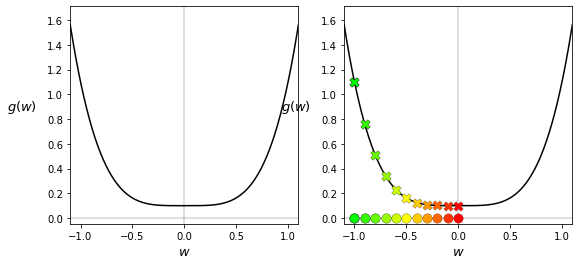

In [20]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**4 + 0.1
# run gradient descent 
w = -1.0; max_its = 10; alpha_choice = 0.1;
version = 'full'
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,version)
# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history],[cost_history],wmin = -1.1,wmax = 1.1)

### Example: Ameliorating the slow-crawling behavior of gradient descent near saddle points

\begin{equation*}
g(w) = \text{maximum}(0,(3w - 2.3)^3 + 1)^2 + \text{maximum}(0,(-3w + 0.7)^3 + 1)^2
\end{equation*}

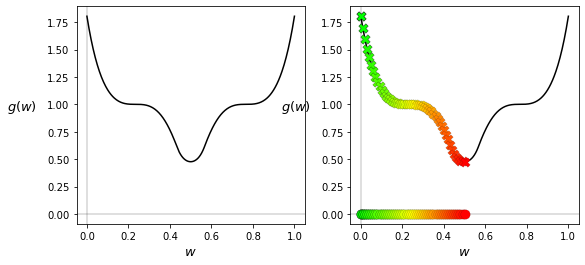

In [21]:
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2
demo_1.draw_2d(g=g, w_inits = [0],steplength = 0.01,max_its = 50,version = 'normalized',wmin = 0,wmax = 1.0)

### Example: Slow-crawling behavior of gradient descent in large flat regions of a function

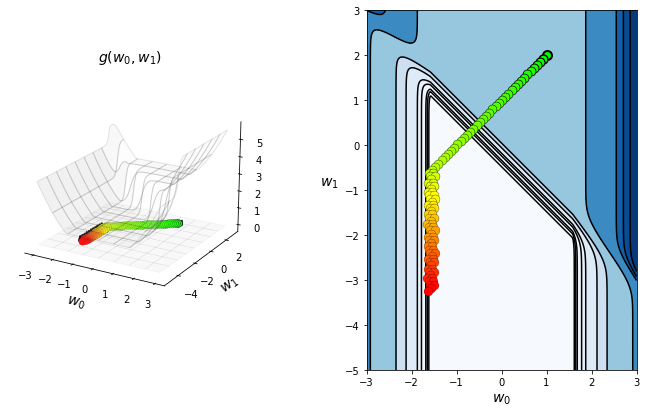

In [22]:
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(0.4*w[0]**2,1) + 1
w = np.array([1.0,2.0]); max_its = 100; alpha_choice = 10**(-1);
version = 'full'
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,version)
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,300],num_contours = 20,xmin = -3,xmax = 3,ymin = -5,ymax = 3)

## Normalizing out the magnitude component-wise

The **<font color='red'>gradient</font>** is a vector of $N$ <font color='blue'>*partial derivatives*</font> 

\begin{equation}
\nabla g(\mathbf{w}) = \begin{bmatrix} 
\frac{\partial}{\partial w_1}g\left(\mathbf{w}\right) \\
\vdots \\
\frac{\partial}{\partial w_N}g\left(\mathbf{w}\right) \\
\end{bmatrix}
\end{equation}

with the $j^{th}$ partial derivative $\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)$ defining how the gradient behaves along the $j^{th}$ coordinate axis.

- Look at the $j^{th}$ partial derivative when we normalize off the <font color='red'>*full magnitude*</font>:
    
\begin{equation*}
\frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\left\Vert \nabla g\left(\mathbf{w}\right) \right\Vert_2} = \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\sqrt{\sum_{n=1}^N \left(\frac{\partial}{\partial w_n}g\left(\mathbf{w}\right)\right)^2}}
\end{equation*}

we can see that <font color='blue'>*the $j^{th}$ partial derivative is normalized using a sum of the magnitudes of every partial derivative*</font>.    

\begin{equation*}
\frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\left\Vert \nabla g\left(\mathbf{w}\right) \right\Vert_2} = \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\sqrt{\sum_{n=1}^N \left(\frac{\partial}{\partial w_n}g\left(\mathbf{w}\right)\right)^2}}
\end{equation*}
- If the $j^{th}$ partial derivative is already small, this normalization will erase all of its contribution to the descent step.
- This is problematic when dealing with functions containing regions that are flat with respect to only some of partial derivative directions.

- An alternative is to normalize out the magnitude component-wise:

\begin{equation*}
\frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\sqrt{\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)\right)^2}} = \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\left|\frac{\partial}{\partial w_j} g\left(\mathbf{w}\right)\right|} = \text{sign}\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)\right)
\end{equation*}    

- So in the $j^{th}$ direction, the component-normalized gradent descent step is:

\begin{equation*}
w_j^k = w_j^{k-1} - \alpha \, \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)}{{\sqrt{\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right)^2}}} = w_j^{k-1} - \alpha \, \text{sign}\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right).
\end{equation*}    

- We can write the entire component-wise normalized step as:

\begin{equation*}
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)
\end{equation*}

- The length of a single step of this component-normalized gradient descent step is:
    
    
\begin{equation*}
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert -\alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)  \right\Vert_2  = \sqrt{N} \, \alpha
\end{equation*}

- If we slightly rewrite the $j^{th}$ component-normalized step as:
\begin{equation*}
w_j^k = w_j^{k-1} - \frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_j} g\left(\mathbf{w}^{k-1}\right)\right)^2} } \, \frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right).
\end{equation*}
then we can interpret the component-normalized step as a standard gradient descent step with an individual steplength value $\frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_j} g\left(\mathbf{w}^{k-1}\right)\right)^2}}$ per component that all *adjusts themselves individually at each step based on component-wise magnitude of the gradient to ensure that the length of each step is precisely $\sqrt{N} \, \alpha$*

- We write 

\begin{equation*}
\mathbf{a}^{k-1} = \begin{bmatrix} 
\frac{\alpha}{\sqrt{\left(\frac{\partial}{(\partial w_1} g\left(\mathbf{w}^{k-1}\right)\right)^2}}  \\
\frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_2} g\left(\mathbf{w}^{k-1}\right)\right)^2}}  \\
\vdots \\
\frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_N} g\left(\mathbf{w}^{k-1}\right)\right)^2}}  \\
\end{bmatrix}
\end{equation*}

- The full component-normalized descent step can be written as:
    
\begin{equation*}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \mathbf{a}^{k-1} \odot \nabla g(\mathbf{w}^{\,k-1})
\end{equation*}

where the $\odot$ symbol denotes component-wise multiplication. In practice,  a small $\epsilon > 0$ is added to the denominator of each value of each entry of $\mathbf{a}^{k-1}$ to avoid division by zero. 

- The above formula is equivalent to 

\begin{equation*}
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)
\end{equation*}

### Example: Full versus component-normalized gradient descent

\begin{equation*}
g(w_0,w_1) = \text{max}\left(0,\text{tanh}(4w_0 + 4w_1)\right) + \text{max}(0,\text{abs}\left(0.4w_0\right)) + 1
\end{equation*}
- This function is very flat along the $w_1$ direction for any fixed value of $w_0$.
- It has a very narrow valley leading toward its minima in the $w_1$ dimension where $w_0=0$.

In [23]:
g = lambda w: np.max(np.tanh(4*w[0] + 4*w[1]),0) + np.max(np.abs(0.4*w[0]),0) + 1
w = np.array([2.0,2.0]); max_its = 1000; alpha_choice = 10**(-1);
version = 'full'
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,version)

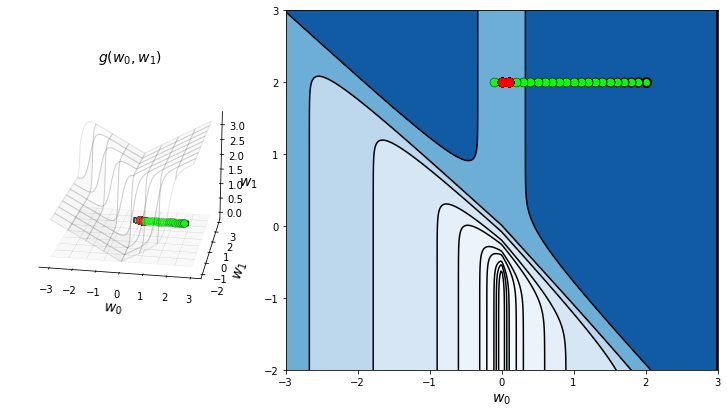

In [24]:
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,280],num_contours = 24,xmin = -3,xmax = 3,ymin = -2,ymax = 3)

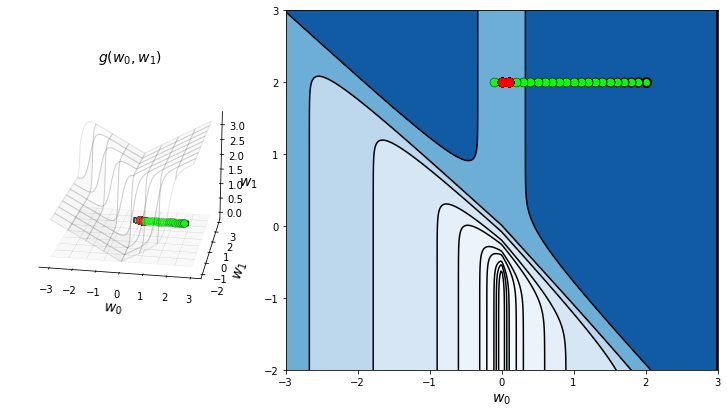

In [25]:
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,280],num_contours = 24,xmin = -3,xmax = 3,ymin = -2,ymax = 3)

- When we use the fully normalized version, the magnitude of the partial derivative in $w_1$ is nearly zero everywhere, so fully-normalizing makes this contribution smaller and halts progress. The demo shows 1000 steps.

In [26]:
# define function
g = lambda w: np.max(np.tanh(4*w[0] + 4*w[1]),0) + np.max(np.abs(0.4*w[0]),0) + 1

w = np.array([2.0,2.0]); max_its = 50; alpha_choice = 10**(-1);
version = 'component'
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,version)

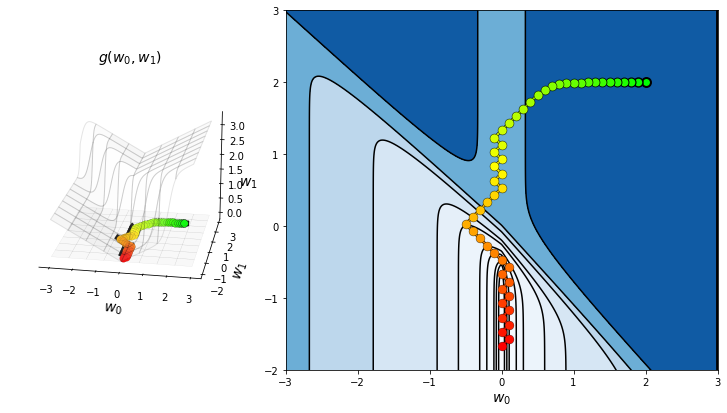

In [27]:
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,280],num_contours = 24,xmin = -3,xmax = 3,ymin = -2,ymax = 3)

- To make progress, we need to enhance the partial derivative in the $w_1$ direction via the component-normalization scheme. Here we need only 50 steps.

# Advanced Gradient-Based Methods

## Combining momentum with normalized gradient descent

- We know that **<font color='red'>momentum-accelerated gradient descent</font>** can ameliorate the zig-zagging problem of standard gradient descent algorithm. The momentum-accelerated descent direction $\mathbf{d}^{k-1}$ is simply an *exponential average* of gradient descent directions taking the form

\begin{equation}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2}  - \left(1 - \beta\right)\nabla g\left(\mathbf{w}^{k-1}\right) \\
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \, \mathbf{d}^{k-1} \,\,\,\,\,\,\,\,\,\,\,\,\,     \,\,\,\,\,\,\,\,\,\,\,\,\,      \,\,\,
\end{equation}

where $\beta \in \left[0,1 \right]$ is typically set at a value of $\beta = 0.7$ or higher.

- We also know that **<font color='blue'>normalizing the gradient descent direction component-wise</font>** helps to deal with the problem of standard gradient descent has when traversing **flat regions** of a function. A component-normalized gradient descent step take the form:

\begin{equation*}
w_j^k = w_j^{k-1} - \alpha \, \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)}{{\sqrt{\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)\right)^2}}}
\end{equation*}

where in practice of course a small $\epsilon > 0$ (like e.g., $\epsilon = 10^{-8}$) is added to the denominator to avoid division by zero. 

- How about combine momentum with normalizing gradient descent direction?

- For example, we can component-normalize the exponential average descent direction computed in momentum-accelerated gradient descent.

- The update for the $j^{th}$ component of the resulting step:

\begin{equation*}
d^{k-1}_j = \beta \, d^{k-2}_j  - \left(1 - \beta\right)\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right) \\
d^{k-1}_j \longleftarrow  \frac{d^{k-1}_j }{\sqrt{\left(d^{k-1}_j \right)^2}}\\
\end{equation*}

- With a full direction $\mathbf{d}^{k-1}$ commputed like above, we can take a descent step:

\begin{equation*}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \, \mathbf{d}^{k-1}. 
\end{equation*}    

- There are many different ways for combining these two enhancements.

## Adaptive Moment Estimation (Adam)

- Adam has <font color='red'>component-wised normalized gradient steps</font> that calculates exponential averages for both the descent direction and magnitude.

- We compute the $j^{th}$ coordinate of the updated descent direction by:
    1. Computing the exponential average of the <font color='red'>gradient descent direction $d^{k}_j$</font> 
    2. Computing the exponential average of the <font color='blue'>squared magnitude $h^{k}_j$</font>.
    
\begin{equation}
\begin{array}
\
d^{k-1}_j = \beta_1 \, d^{k-2}_j  + \left(1 - \beta_1\right)\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right) \\
h_j^{k-1} = \beta_2 \, h_j^{k-2} + \left(1 - \beta_2\right)\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right)^2
\end{array}
\end{equation}

where $\beta_1$ and $\beta_2$ lie in the range $[0,1]$.  Popular values the parameters of this update step are $\beta_1 = 0.9$, $\beta_2 = 0.999$.

- These two updates apply when $k>1$ and should be initialized as $d^0_j = \frac{\partial}{\partial w_j}g\left(\mathbf{w}^{0}\right)$ and its squared magnitude $h^0_j = \left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{0}\right)\right)^2$.

- The original Adam's publication used a slightly different initialization with bias-correction.

## Adaptive Moment Estimation (Adam)

- The Adam update step is a component-normalized descent step using the exponentially average descent direction and magnitude.

- A step in the $j^{th}$ coordinate then takes the form

\begin{equation}
w_j^k = w_j^{k-1} - \alpha \frac{d^{k-1}_j}{\sqrt{h_j^{k-1}}}.
\end{equation}

where in practice of course a small $\epsilon > 0$ (like e.g., $\epsilon = 10^{-8}$) is added to the denominator to avoid division by zero.  

- If we slightly re-write above as

\begin{equation*}
w_j^k = w_j^{k-1} - \frac{\alpha}{\sqrt{h_j^{k-1}}} \, d^{k-1}_j.
\end{equation*}

we can interpret the Adam step as a <font color='red'>momentum-accelerated gradient descent step</font> with an individual steplength $\frac{\alpha}{\sqrt{h_j^{k-1}}}$ per component that all <font color='blue'>*adjusts themselves individually at each step based on component-wise exponentially normalized magnitude of the gradient*</font>.

## Root Mean Squared Propagation (RMSprop)

- In component-wise normalized gradient descent, each component of the gradient is normalized by its magnitude.

- We can normalize each component of the gradient by the **<font color='red'>exponential average of the component-wise magnitudes</font>** of previous gradient directions.

- The exponential average of the squared magnitude of the $j^{th}$ partial derivative at step $k$ as:


\begin{equation*}
h_j^k = \gamma \, h_j^{k-1} + \left(1 - \gamma\right)\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right)^2
\end{equation*}

- The **<font color='red'>RMSprop</font>** step is a component-wise normalized descent step using the above exponential average:

\begin{equation*}
w_j^k = w_j^{k-1} - \alpha \frac{\frac{\partial}{\partial w_j} g\left(\mathbf{w}^{k-1}\right)}{\sqrt{h_j^{k-1}}}
\end{equation*}
where in practice of course a small $\epsilon > 0$ (like e.g., $\epsilon = 10^{-8}$) is added to the denominator to avoid division by zero.    

## Root Mean Squared Propagation (RMSprop)

\begin{equation*}
w_j^k = w_j^{k-1} - \alpha \frac{\frac{\partial}{\partial w_j} g\left(\mathbf{w}^{k-1}\right)}{\sqrt{h_j^{k-1}}}
\end{equation*}

We can re-write the above update step as:
    
\begin{equation*}
w_j^k = w_j^{k-1} - \frac{\alpha}{\sqrt{h_j^{k-1}}} \, \frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right).
\end{equation*}

We can interpret the RMSprop step as a standard gradient descent step with an <font color='red'>individual steplength</font> value $\frac{\alpha}{\sqrt{h_j^{k-1}}}$ per component that all <font color='blue'>*adjusts themselves individually at each step based on component-wise magnitude of the gradient*</font>.